In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.append('../')
from misc import h5file
import numpy as np

import scipy.io as sio
import sympy
from sympy import Symbol, parse_expr, sympify, lambdify, Lambda

import pandas as pd
import subprocess

from scipy.optimize import curve_fit

MAIN_SEED = 1234

In [2]:
fp1 = "./IPI_output_files/PMS_data.h5"

In [3]:
_, _, un, _ = h5file(file_path=fp1, mode='r', return_dict=False)

['X_pre', 'best_subsets', 'un', 'y_pre']


In [4]:
data = sio.loadmat('../Datasets/burgers.mat')
x = data['x'].real.reshape(-1, 1)
del data

In [5]:
from pysr import PySRRegressor

deterministic = True

if not deterministic:
    model = PySRRegressor(
        niterations=50,  # < Increase me for better results
        binary_operators=["+", "*"],
        unary_operators=["exp", "square"], 
        deterministic=deterministic
    )
else:
    np.random.seed(MAIN_SEED)
    model = PySRRegressor(
        niterations=50,  # < Increase me for better results
        binary_operators=["+", "*"],
        unary_operators=["exp", "square"], 
        # For a deterministic result
        deterministic=deterministic, 
        random_state=MAIN_SEED, 
        procs=0, 
        multithreading=False
    )

In [6]:
model.fit(x, un[:,0])

/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/pysr/sr.py:1289: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/pysr/julia_helpers.py:197: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try `pyenv`.
  warnings.warn(


Started!

Cycles per second: 5.690e+04
Progress: 157 / 750 total iterations (20.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.684e-02  1.114e-07  0.113170736
6           6.562e-02  3.704e-03  square(-0.30881372 + (0.01490621 * x0))
7           4.446e-04  4.995e+00  exp(square(x0 + 2.0117266) * -1.0112218)
9           4.444e-04  1.781e-04  exp(square(x0 + square(square(1.1909101))) * -0.99798566)
11          4.438e-04  6.249e-04  square(square(exp(square(x0 + square(square(1.1909101))) * -0....
                                  25102076)))
15          4.420e-04  1.010e-03  exp(square((x0 + -0.013938772) + square(square(1.1909101))) * ...
                                  (-1.0366871 + (-0.013938772 * x0)))
16          4.415e-04  1.299e-03  square(exp(square((square(-2.0019612) + x0) + -2.0019612) * -0...
                                  .5092167) * square(sq

PySRRegressor.equations_ = [
	   pick     score                                           equation   
	0        0.000000                                        0.113170736  \
	1        0.008301                 (0.10588875 + (-0.011782348 * x0))   
	2  >>>>  2.490723           exp(square(x0 + 2.0116963) * -1.0041662)   
	3        0.003389  exp((square(x0 + 2.0116963) + -0.0042296816) *...   
	4        0.002992  (exp(square(x0 + 2.0116963) * -1.0041662) + sq...   
	5        0.005820  (exp(square(x0 + 2.0116963) * -1.0041662) + sq...   
	6        0.000009  (exp(square(x0 + 2.0116963) * -1.0041662) + sq...   
	7        0.002957  exp(square(x0 + square(square(1.1909101))) * (...   
	8        0.003679  square(square(exp(square(x0 + (square(square(1...   
	9        0.007481  square(square(exp(square(x0 + (square(square(1...   
	
	       loss  complexity  
	0  0.066843           1  
	1  0.064660           5  
	2  0.000444           7  
	3  0.000441           9  
	4  0.000440          10  
	5  0.000437          11  
	6  0.000437          13  
	7  0.000436          14  
	8  0.000432          16  
	9  0.000426          18  
]

In [9]:
# save_to = f"./hall/hof.csv"
# model.get_hof().to_csv(save_to, index=None)
# subprocess.run(["bash", "clean_pysr.sh"])
# print(save_to)

./hall/hof.csv


rm: hall_of_fame_*: No such file or directory


In [10]:
hof = pd.read_csv(save_to)
# hof = model.get_hof()

In [11]:
equation = hof.iloc[np.argmax(hof["score"])]

In [12]:
import re
from functools import partial
from simpleeval import simple_eval
from py_expression_eval import Parser
from sympy import Symbol

def extract_function(equation):
    floats = re.findall("\d+\.\d+", equation.equation)
    notaions = [chr(97+i) for i in range(len(floats))]
    ind_notations = Parser().parse(equation.sympy_format).variables()
    new_equation = equation.equation
    for f,n in zip(floats, notaions):
        new_equation = new_equation.replace(f, n)
    function = lambdify(args=list(map(Symbol, ind_notations+notaions)), 
                        expr=new_equation)
    return function, ind_notations, dict(zip(notaions, map(float, floats)))

function, ind_notations, args = extract_function(equation)
# function = partial(function, **dict(zip(notaions, map(float, floats))))
# ((function(x)-un[:, 0:1])**2).mean()

In [13]:
print(equation.sympy_format) # exp(-1.0219623 * square(1.9614727 + x0))
func = lambdify(args=sympy.symbols('x0'), expr=equation.sympy_format)
# deter: 0.0006665787665166545
# non-deter-1: 0.0006665787695548446
((np.vectorize(func)(x)-un[:, 0:1])**2).mean()

exp(-4.0637822898844*(0.497092926004785*x0 + 1)**2)


0.00044383308825338683

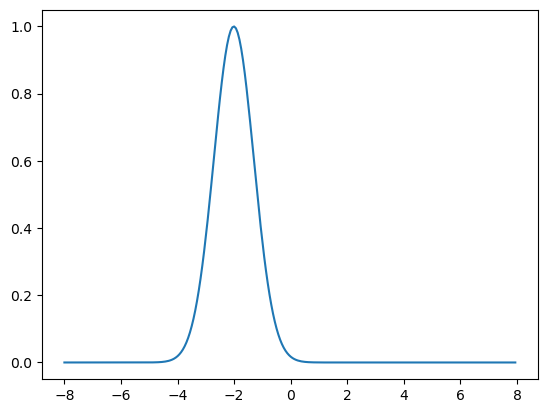

In [14]:
plt.plot(x.flatten(), partial(function, **args)(x))
plt.show()

[2.01169575 1.00414883]
0.00044383308388849547


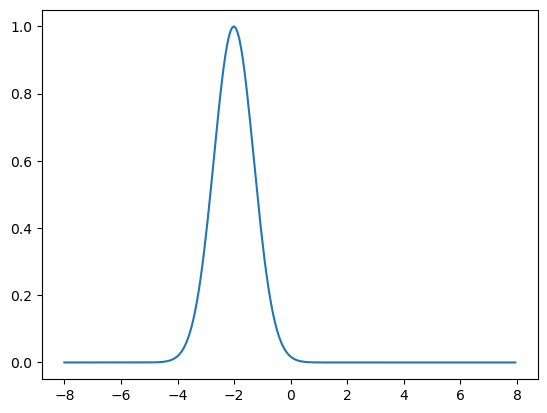

In [15]:
recovered_params = curve_fit(function, x.flatten(), un[:, 0])[0]
print(recovered_params)
print(((function(x, *recovered_params)-un[:, 0:1])**2).mean())
plt.plot(x, function(x, *recovered_params))
plt.show()

In [16]:
def func(x, a, b):
    return np.exp(np.square(x+a)*b)

[ 2.01169571 -1.00414888]
0.0004438330838882192


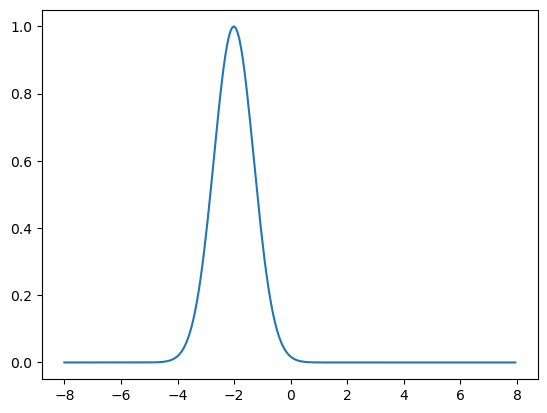

In [17]:
recovered_params = curve_fit(func, x.flatten(), un[:, 0])[0]
print(recovered_params)
print(((func(x, *recovered_params)-un[:, 0:1])**2).mean())
plt.plot(x, func(x, *recovered_params))
plt.show()

In [18]:
# np.save("./tmp_files/u0_est.npy", np.array([func(e) for e in x.flatten()]).astype(np.float32))

#### Sympy -> Torch

In [17]:
import torch, sympytorch

In [18]:
x_ = torch.tensor(x.flatten()).float()

In [19]:
# automatic way of getting learnable parameters
sympy_equation = sympify(equation.sympy_format)
sympy_equation

# sympy_equation = parse_expr(equation.equation, 
#                             local_dict={"square": square, "exp":sympy.exp})

# x0 = Symbol('x0', real=True)
# square = Lambda(x0, x0**2)
# sympy_equation = sympify(equation.equation, locals={"square": square, "exp":sympy.exp}, 
#                evaluate=True, rational=False)

exp(-4.1507986414173*(0.496318754168457*x0 + 1)**2)

In [20]:
# automatic way of getting learnable parameters
mod = sympytorch.SymPyModule(expressions=[sympy_equation])

0.0006418376738908429


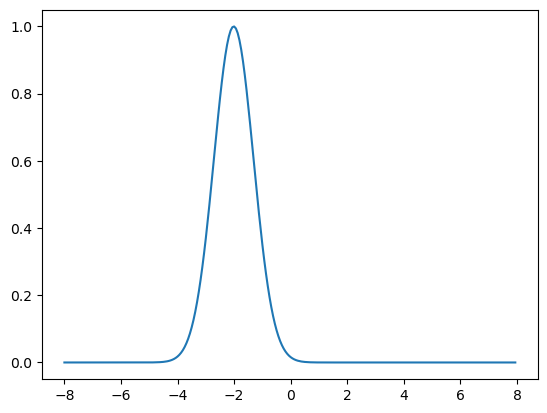

In [21]:
plt.plot(x, mod(x0=x_).detach().numpy())
print(((mod(x0=x_).detach().numpy()-un[:, 0:1])**2).mean())
plt.show()

In [22]:
# PARTIAL CONTROL on the learnable parameters
x0 = Symbol("x0")
x1 = Symbol("x1")
a, b = recovered_params
manual_equation = sympy.exp(b*((x0+a)**2))
mod = sympytorch.SymPyModule(expressions=[manual_equation])
print(((mod(x0=x_).detach().numpy()-un[:, 0:1])**2).mean())

0.0006418377944037246


In [23]:
# FULLL CONTROL on the learnable parameters
mod1 = sympytorch.SymPyModule(expressions=[x0+a])
mod2 = sympytorch.SymPyModule(expressions=[sympy.exp(b*x1**2)])
print(((mod2(x1=mod1(x0=x_).flatten()).detach().numpy()-un[:, 0:1])**2).mean())
list(mod1.parameters()), list(mod2.parameters())

0.0006418377469256779


([Parameter containing:
  tensor(2.0148, requires_grad=True)],
 [Parameter containing:
  tensor(-1.0225, requires_grad=True)])

In [24]:
sympy_equation

exp(-4.1507986414173*(0.496318754168457*x0 + 1)**2)

In [25]:
func = lambdify(args=sympy.symbols('x0'), expr="exp(-1. * square(2. + x0))")
# deter: 0.0006665787665166545
# non-deter-1: 0.0006665787695548446
((np.vectorize(func)(x)-un[:, 0:1])**2).mean()

0.0006664011032748716

In [26]:
expr = sympify(equation.equation)

In [27]:
numbers = [atom for atom in sympify(equation.equation).atoms() if atom.is_number]

In [28]:
numbers

[-1.02247580000000, 2.01483420000000]